### Import the Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import joblib
warnings.filterwarnings('ignore')


### Import Libraries and Load Dataset

In [2]:
# Load the dataset from a remote Excel file, parsing 'InvoiceDate' as datetime
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx', parse_dates=['InvoiceDate'])

# Display the first few rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Exploration and Pre-Processing

In [3]:
# Print the shape of the dataset
df.shape

(541909, 8)

In [4]:
# Display concise summary information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Print the column names of the dataset
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Check the number of unique values in each column
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [8]:
print("There are {} duplicated values.".format(df.duplicated().sum()))
df[df.duplicated(keep=False)].head(4)

There are 5268 duplicated values.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom


In [9]:
new_data = df.drop_duplicates()
new_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [10]:
new_data.duplicated().sum()

0

In [11]:
# Check the data types of each column
data_types = new_data.dtypes
print(data_types)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [12]:
new_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [13]:
# Calculate percentage of null values in each column
null_percentage = (new_data.isnull().sum() / len(new_data)) * 100
print("Percentage of Null Values in Each Column:")
print(null_percentage)

Percentage of Null Values in Each Column:
InvoiceNo       0.000000
StockCode       0.000000
Description     0.270945
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.163377
Country         0.000000
dtype: float64


In [14]:
# select the portion of dataframe with no missing values for the column "CustomerID"
clean_data = new_data[pd.notnull(new_data["CustomerID"])]
clean_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
# Calculate total transactions by country
total_transactions_by_country = clean_data.groupby('Country')['InvoiceNo'].count().reset_index()
total_transactions_by_country.columns = ['Country', 'Total Transactions']

# Calculate total transactions across all countries
total_transactions_all_countries = total_transactions_by_country['Total Transactions'].sum()

# Calculate percentage of total transactions for each country
total_transactions_by_country['Percentage of Total Transactions'] = (total_transactions_by_country['Total Transactions'] / total_transactions_all_countries) * 100
print(total_transactions_by_country)

                 Country  Total Transactions  Percentage of Total Transactions
0              Australia                1258                          0.313244
1                Austria                 401                          0.099850
2                Bahrain                  17                          0.004233
3                Belgium                2069                          0.515184
4                 Brazil                  32                          0.007968
5                 Canada                 151                          0.037599
6        Channel Islands                 757                          0.188494
7                 Cyprus                 611                          0.152140
8         Czech Republic                  30                          0.007470
9                Denmark                 389                          0.096862
10                  EIRE                7475                          1.861286
11    European Community                  61        

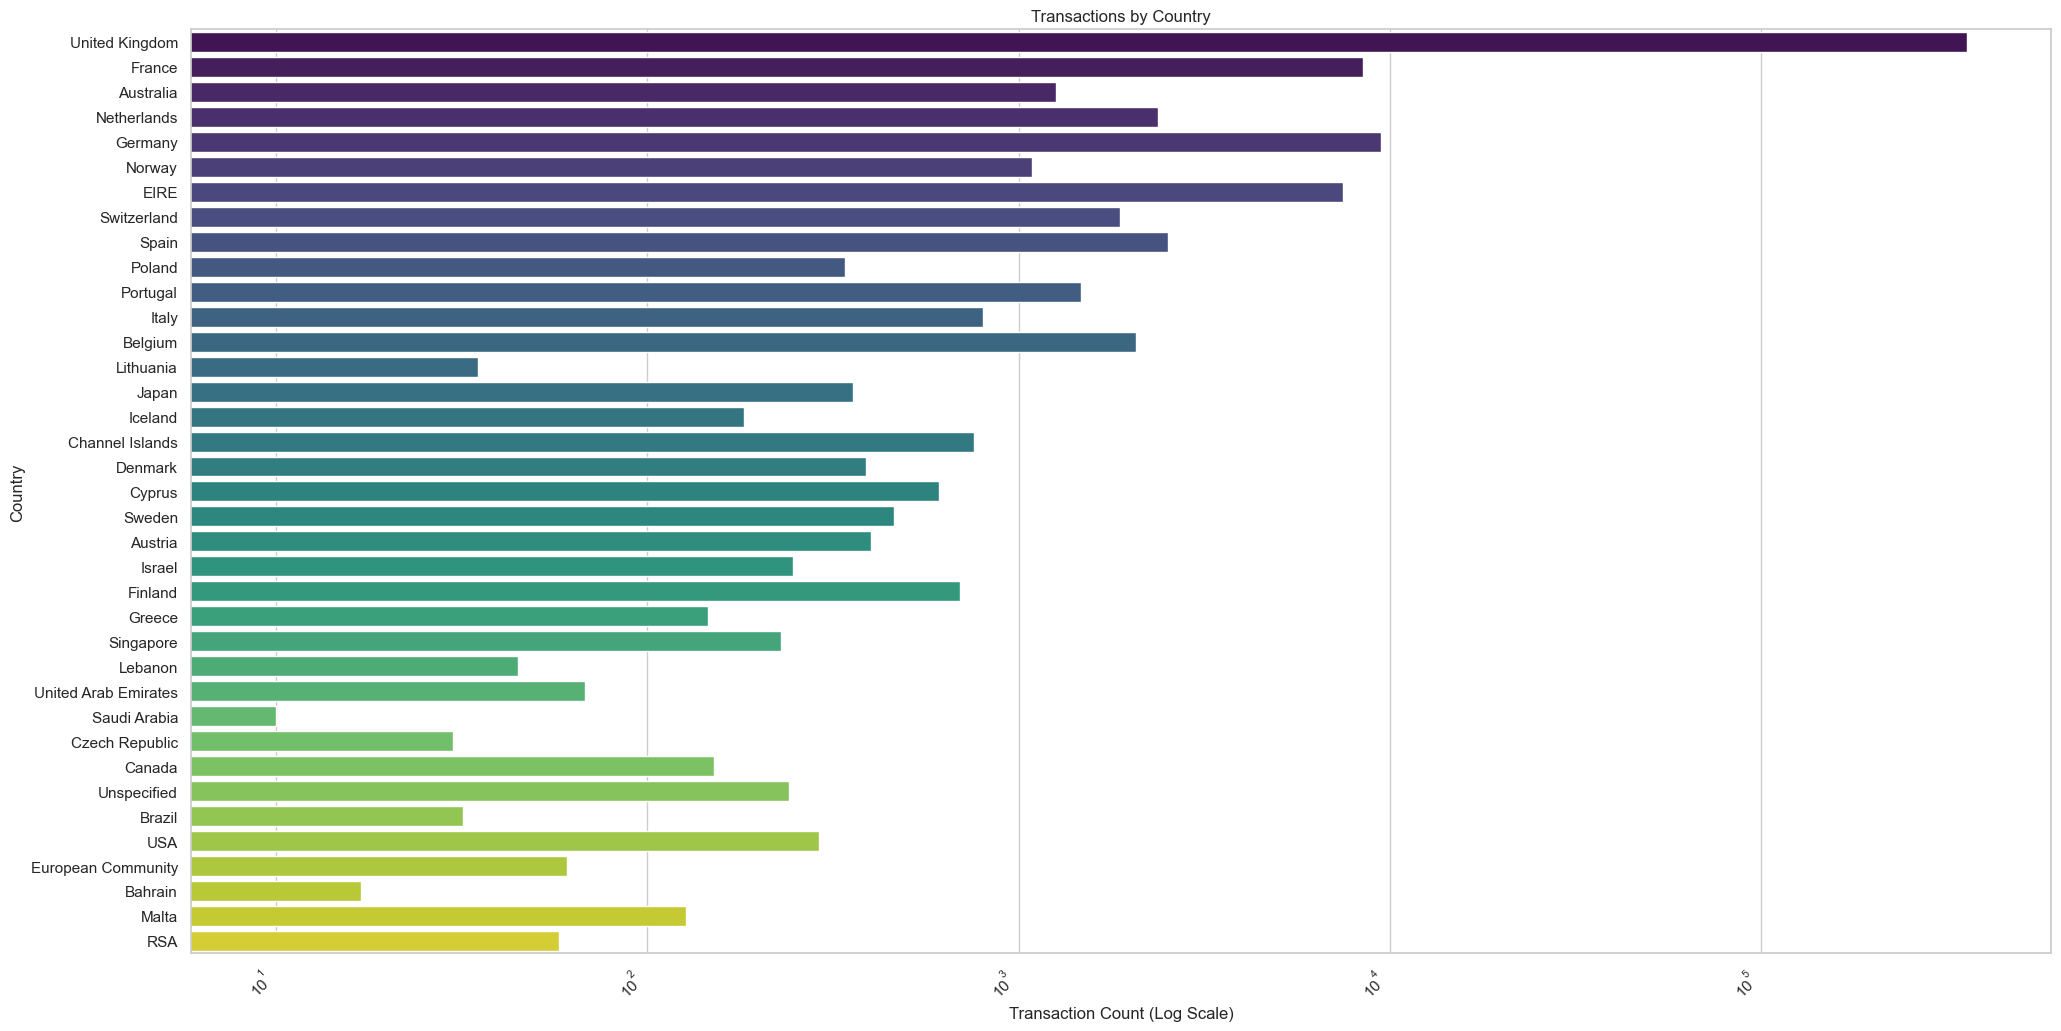

In [19]:
# Plot the count of transactions by country with log-transformed x-axis
sns.set(style="whitegrid")
plt.figure(figsize=(24, 12))
sns.countplot(data=clean_data, y='Country', palette='viridis')
plt.title('Transactions by Country')
plt.xlabel('Transaction Count (Log Scale)')
plt.ylabel('Country')
plt.xscale('log')
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
# Calculate the distribution of transactions across different countries
transactions_by_country = clean_data['Country'].value_counts()
print("Distribution of Transactions Across Different Countries:")
print(transactions_by_country)

# Calculate the countries with the highest and lowest number of transactions
highest_transactions_country = transactions_by_country.idxmax()
lowest_transactions_country = transactions_by_country.idxmin()
print("\nCountry with the Highest Number of Transactions:", highest_transactions_country)
print("Country with the Lowest Number of Transactions:", lowest_transactions_country)

# Calculate the market penetration as a percentage for each country
total_transactions = len(clean_data)
market_penetration = (transactions_by_country / total_transactions) * 100
print("\nMarket Penetration Across Different Countries:")
print(market_penetration)

Distribution of Transactions Across Different Countries:
United Kingdom          356728
Germany                   9480
France                    8475
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA          

In [26]:
# filter customers from United Kingdom
data = clean_data[clean_data["Country"] == "United Kingdom"]

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356728 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356728 non-null  object        
 1   StockCode    356728 non-null  object        
 2   Description  356728 non-null  object        
 3   Quantity     356728 non-null  int64         
 4   InvoiceDate  356728 non-null  datetime64[ns]
 5   UnitPrice    356728 non-null  float64       
 6   CustomerID   356728 non-null  float64       
 7   Country      356728 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.5+ MB


In [28]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284
std,264.998044,71.162330,1594.286219
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [29]:
# Calculate the range of dates in the dataset
date_range = pd.to_datetime(data.InvoiceDate.max()) - pd.to_datetime(data.InvoiceDate.min())
print(date_range)

373 days 04:23:00


In [30]:
data.min()
# why will quantity be negative?

Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                               -80995
InvoiceDate               2010-12-01 08:26:00
UnitPrice                                 0.0
CustomerID                            12346.0
Country                        United Kingdom
dtype: object

In [31]:
# Filter the DataFrame to show rows where Quantity is negative
negative_quantity_data = data[data['Quantity'] < 0]
print(negative_quantity_data)

       InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-12-01 09:41:00      27.50     1

In [32]:
data.max()

Description    ZINC WIRE SWEETHEART LETTER TRAY
Quantity                                  80995
InvoiceDate                 2011-12-09 12:49:00
UnitPrice                               38970.0
CustomerID                              18287.0
Country                          United Kingdom
dtype: object

In [33]:
# Filter out returns (transactions with negative quantity)
data = data[data['Quantity'] >= 0]
print(data)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [34]:
# Describe the Quantity column
data.Quantity.describe()

count    349227.000000
mean         12.181295
std         191.797470
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [35]:
# Create a new column 'Sales' by multiplying 'Quantity' and 'UnitPrice'
data.loc[:, 'Sales'] = data['Quantity'] * data['UnitPrice']
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Sales  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34  


In [36]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [37]:
# Extract additional date features
data.insert(4, 'Day', data['InvoiceDate'].dt.day)
data.insert(5, 'Month', data['InvoiceDate'].dt.month)
data.insert(6, 'Year', data['InvoiceDate'].dt.year)
data.insert(7, 'WeekDay', data['InvoiceDate'].dt.weekday)
data.insert(8, 'Hour', data['InvoiceDate'].dt.hour)
data.insert(9, 'Minute', data['InvoiceDate'].dt.minute)
data.insert(10, 'Date', data['InvoiceDate'].dt.date)

In [38]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,Day,Month,Year,WeekDay,Hour,Minute,Date,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1,12,2010,2,8,26,2010-12-01,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


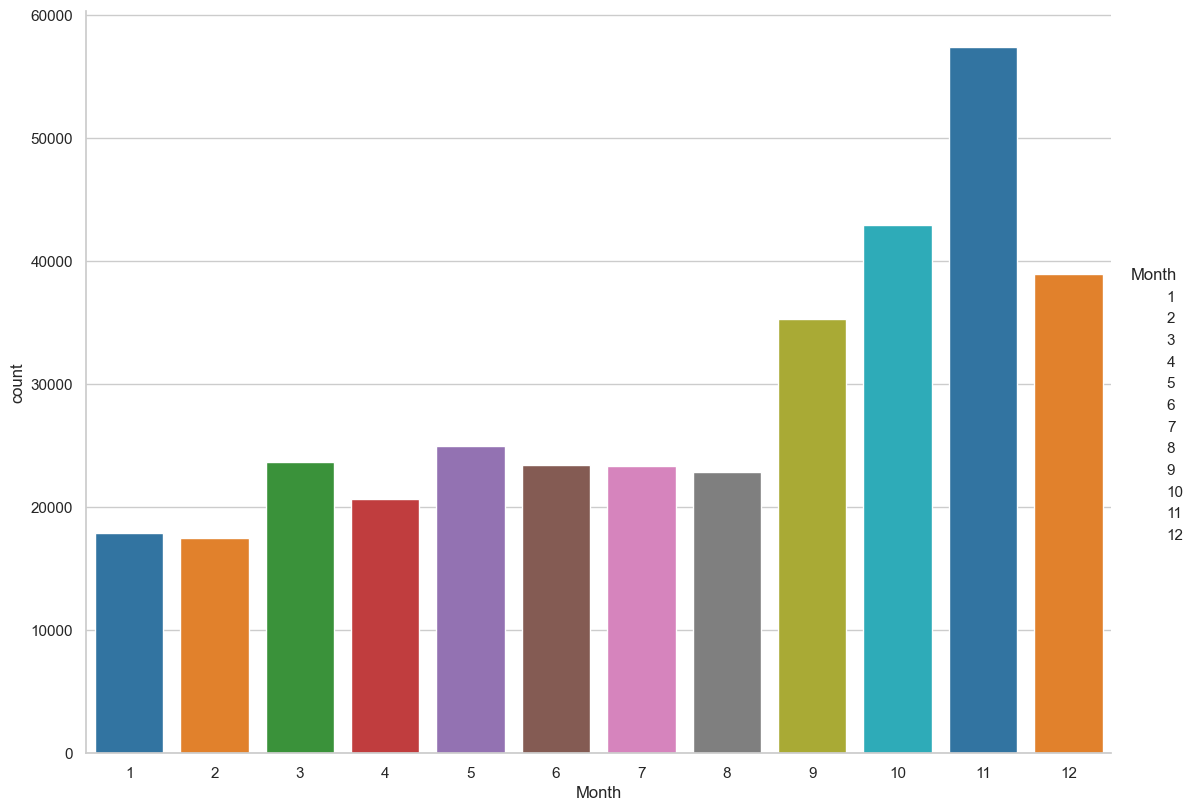

In [39]:
# Define a custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Plot the count of transactions by month
sns.catplot(data=data, x='Month', kind='count', palette=custom_palette, height=8.27, aspect=11/8)

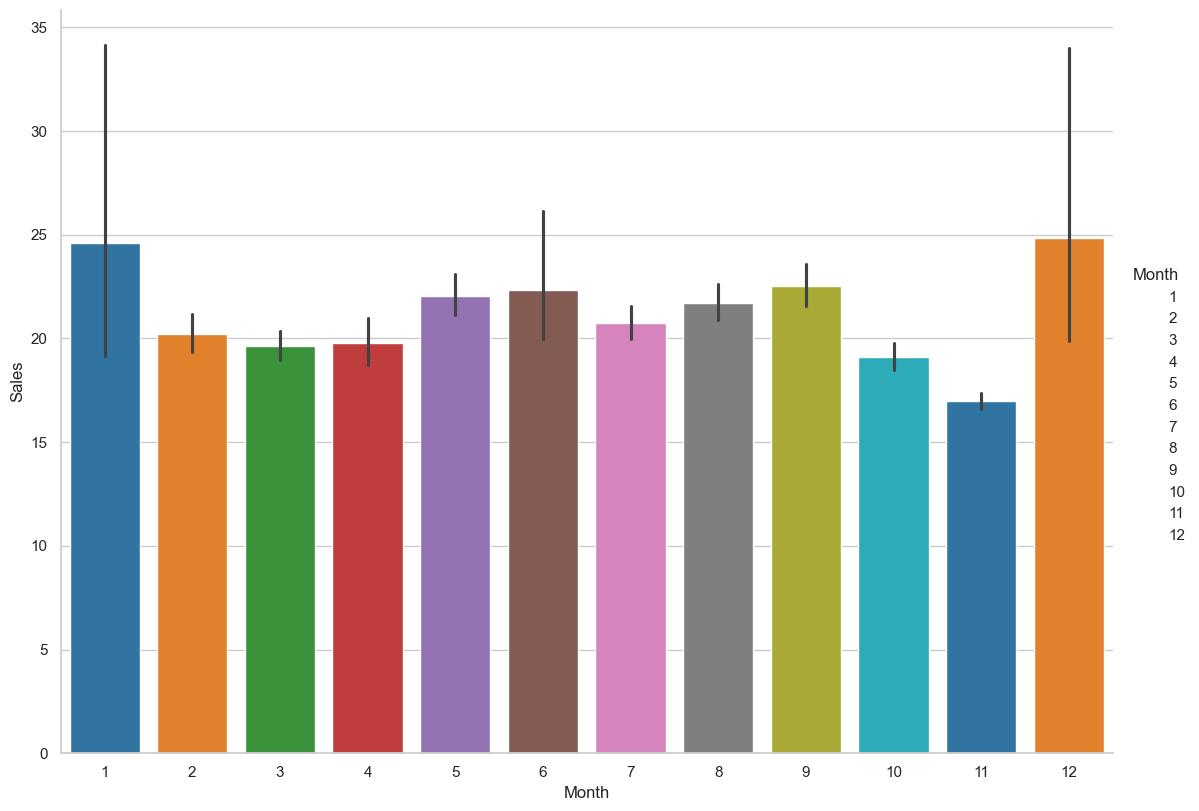

In [40]:
# Plot sales by month
sns.catplot(data=data, x='Month', y='Sales', kind='bar', palette=custom_palette, height=8.27, aspect=11/8)

Text(0.5, 1.0, 'Sales By WeekDay ')

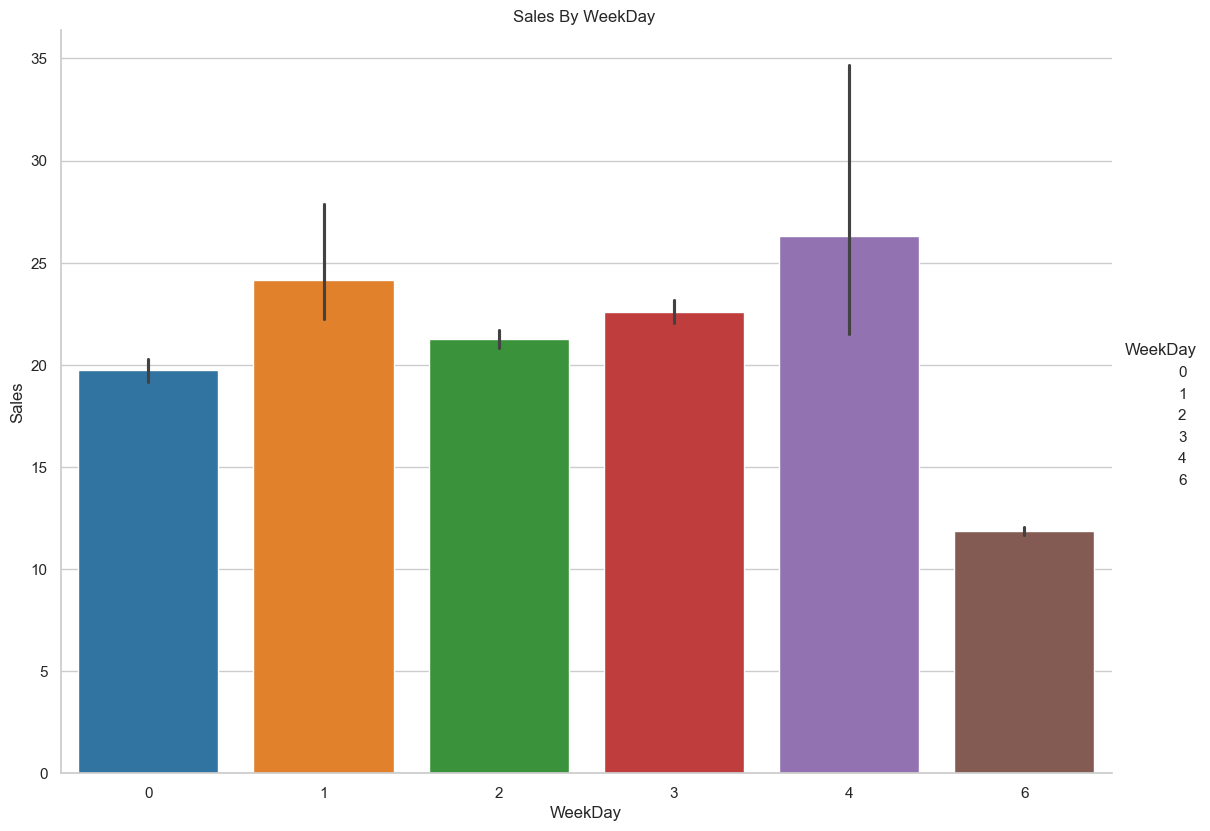

In [41]:
sns.catplot(data=data, x= 'WeekDay', y='Sales', kind = 'bar', palette=custom_palette, height=8.27, aspect=11/8)
plt.title('Sales By WeekDay ')
# Monday = 0 to Sunday = 6

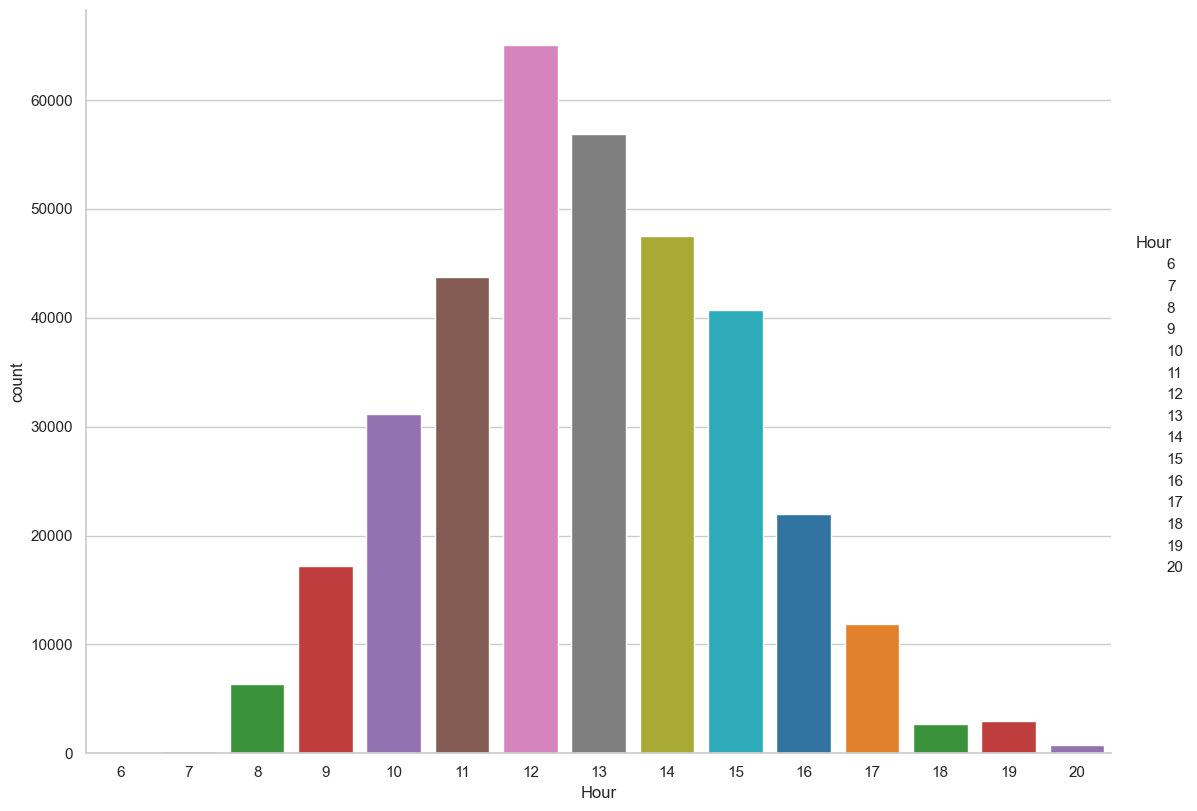

In [42]:
# Plot the count of transactions by hour
sns.catplot(data=data, x='Hour', kind='count', palette=custom_palette, height=8.27, aspect=11/8)

In [43]:
# Calculate the sum of sales grouped by weekday
sales_by_weekday = data.groupby(['WeekDay']).sum()
sales_by_weekday 

,Quantity,Day,Month,Year,Hour,Minute,UnitPrice,CustomerID,Sales
WeekDay,,,,,,,,,
0,631291,871756,444523,114711713,731300,1739403,181657.971,8.849684e+08,1126022.151
1,842455,886874,433267,117777472,736235,1764136,175586.201,9.094877e+08,1415788.971
2,780894,910441,453700,120882350,759843,1847840,176375.210,9.363256e+08,1276826.580
3,916840,1020566,527970,139182046,924529,2090947,209151.150,1.077830e+09,1563033.230
4,676490,645486,352103,92889525,567105,1405767,135308.561,7.166091e+08,1215510.031
6,406067,913092,454842,116828932,752387,1731290,159866.771,9.046767e+08,687843.681


In [44]:
# Display the counts of each stock code, showing the most frequent ones
stock_code_counts = data['StockCode'].value_counts().head()
stock_code_counts 

85123A    1936
85099B    1461
22423     1417
84879     1320
47566     1301
Name: StockCode, dtype: int64

In [45]:
data['CustomerID'].value_counts().head(10)

17841.0    7676
14096.0    5111
12748.0    4413
14606.0    2677
15311.0    2366
13089.0    1814
13263.0    1667
14298.0    1637
15039.0    1477
18118.0    1263
Name: CustomerID, dtype: int64

In [46]:
data['StockCode'].value_counts().head()

85123A    1936
85099B    1461
22423     1417
84879     1320
47566     1301
Name: StockCode, dtype: int64

In [47]:
d_count =  data.Description.value_counts().sort_values(ascending=False).iloc[0:15]
d_count

WHITE HANGING HEART T-LIGHT HOLDER    1929
JUMBO BAG RED RETROSPOT               1461
REGENCY CAKESTAND 3 TIER              1417
ASSORTED COLOUR BIRD ORNAMENT         1320
PARTY BUNTING                         1301
LUNCH BAG RED RETROSPOT               1135
LUNCH BAG  BLACK SKULL.               1022
SET OF 3 CAKE TINS PANTRY DESIGN      1013
PAPER CHAIN KIT 50'S CHRISTMAS         967
HEART OF WICKER SMALL                  946
NATURAL SLATE HEART CHALKBOARD         943
SPOTTY BUNTING                         919
LUNCH BAG CARS BLUE                    893
REX CASH+CARRY JUMBO SHOPPER           888
LUNCH BAG SPACEBOY DESIGN              878
Name: Description, dtype: int64

Text(0.5, 1.0, 'Top 10 Products')

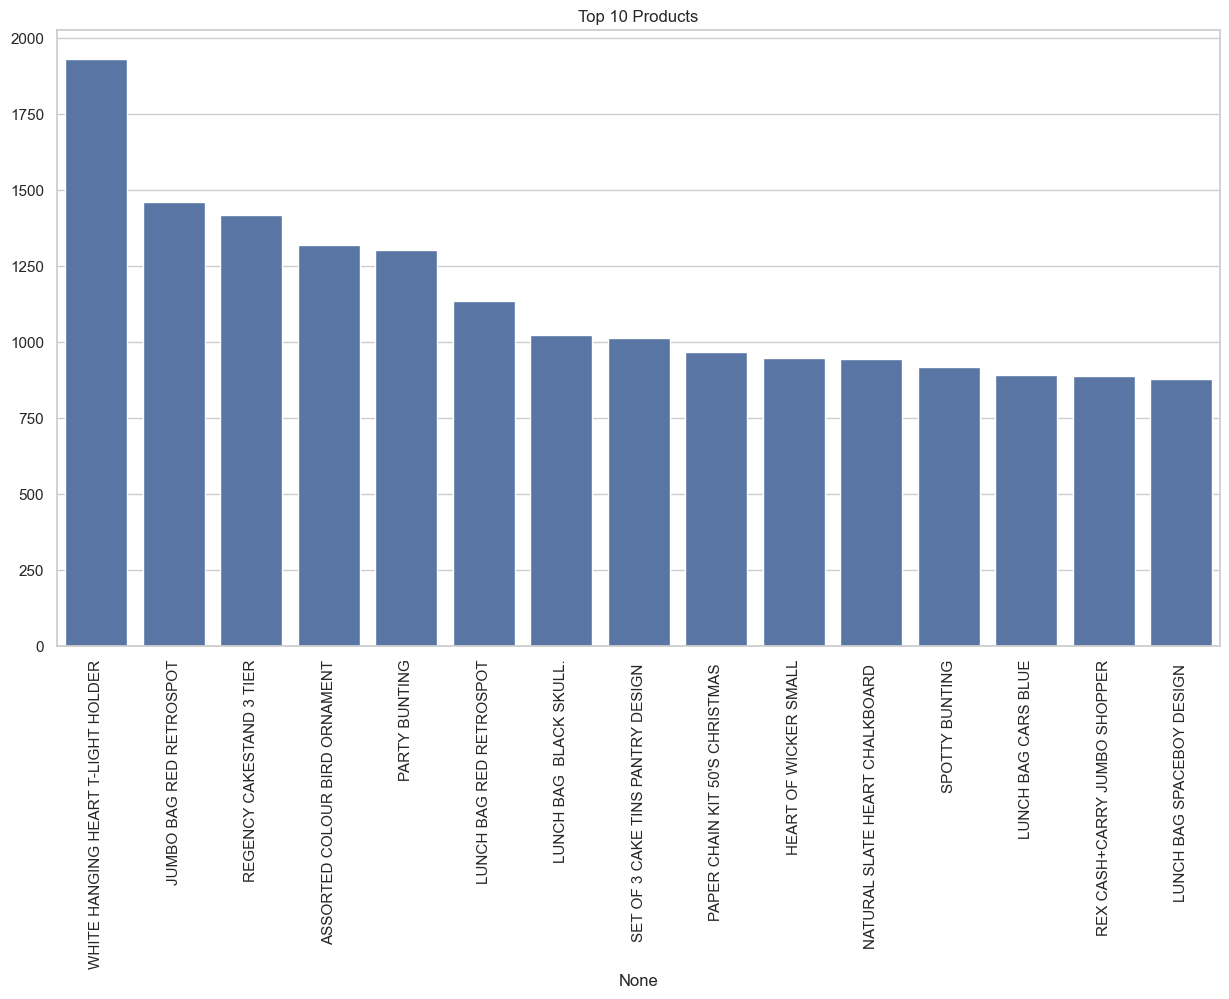

In [48]:
# Display the top 15 most frequent product descriptions
top_products = data['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(15, 8))
sns.barplot(x=top_products.index, y=top_products.values)
plt.xticks(rotation=90)
plt.title('Top 10 Products')

###  Feature Selection (Using Recency, Frequency, and Monetary Value)

In [50]:
 # Calculate RFM Metrics
# Calculate Recency (R)
now = pd.to_datetime('2011-12-09')  # Current date
new_df = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
new_df.columns = ['CustomerID', 'LastPurchaseDate']
new_df['Recency'] = (now - new_df['LastPurchaseDate']).dt.days
new_df.drop('LastPurchaseDate', axis=1, inplace=True)

# Calculate Frequency (F)
new_df2 = data.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
new_df2.columns = ['CustomerID', 'Frequency']

# Calculate Monetary Value (M)
new_df3 = data.groupby(by='CustomerID', as_index=False)['Sales'].sum()
new_df3.columns = ['CustomerID', 'Monetary']

In [51]:
# Merge RFM Metrics
rfm_df = pd.merge(new_df, new_df2, on='CustomerID')
rfm_df = pd.merge(rfm_df, new_df3, on='CustomerID')
rfm_df.set_index('CustomerID', inplace=True)

In [52]:
# Merge RFM Metrics
temp = new_df.merge(new_df2, on='CustomerID')
rfm_df = temp.merge(new_df3, on='CustomerID')
rfm_df.set_index('CustomerID', inplace=True)
rfm_df.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,324,1,77183.60
12747.0,1,103,4196.01
12748.0,-1,4413,33053.19
12749.0,2,199,4090.88
12820.0,2,59,942.34
12821.0,213,6,92.72
12822.0,69,46,948.88
12823.0,73,5,1759.50
12824.0,58,25,397.12


In [53]:
# Assign RFM Quartiles
rfm_df['R_quartile'] = pd.qcut(rfm_df['Recency'], 4, labels=['1', '2', '3', '4'])
rfm_df['F_quartile'] = pd.qcut(rfm_df['Frequency'], 4, labels=['4', '3', '2', '1'])
rfm_df['M_quartile'] = pd.qcut(rfm_df['Monetary'], 4, labels=['4', '3', '2', '1'])

In [54]:
# Calculate RFM Score
rfm_df['RFM_Score'] = rfm_df['R_quartile'].astype(str) + rfm_df['F_quartile'].astype(str) + rfm_df['M_quartile'].astype(str)
rfm_df['RFM_Score'] 

CustomerID
12346.0    441
12747.0    111
12748.0    111
12749.0    111
12820.0    122
          ... 
18280.0    444
18281.0    444
18282.0    144
18283.0    111
18287.0    221
Name: RFM_Score, Length: 3921, dtype: object

In [55]:
# Explore Segments
# Customers with RFM Score 111 are considered as the best customers
best_customers = rfm_df[rfm_df['RFM_Score'] == '111'].head()
print("Best Customers:")
print(best_customers)

Best Customers:
            Recency  Frequency  Monetary R_quartile F_quartile M_quartile  \
CustomerID                                                                  
12747.0           1        103   4196.01          1          1          1   
12748.0          -1       4413  33053.19          1          1          1   
12749.0           2        199   4090.88          1          1          1   
12839.0           1        314   5591.42          1          1          1   
12841.0           3        414   3991.58          1          1          1   

           RFM_Score  
CustomerID            
12747.0          111  
12748.0          111  
12749.0          111  
12839.0          111  
12841.0          111  


In [56]:
# Customers with the lowest Frequency and Monetary Value
low_frequency_customers = rfm_df[rfm_df['F_quartile'] == '1'].head()
low_monetary_customers = rfm_df[rfm_df['M_quartile'] == '1'].head()
print("Customers with Lowest Frequency:")
print(low_frequency_customers)
print("Customers with Lowest Monetary Value:")
print(low_monetary_customers)

Customers with Lowest Frequency:
            Recency  Frequency  Monetary R_quartile F_quartile M_quartile  \
CustomerID                                                                  
12747.0           1        103   4196.01          1          1          1   
12748.0          -1       4413  33053.19          1          1          1   
12749.0           2        199   4090.88          1          1          1   
12836.0          58        174   2610.36          3          1          1   
12838.0          32        120    671.95          2          1          2   

           RFM_Score  
CustomerID            
12747.0          111  
12748.0          111  
12749.0          111  
12836.0          311  
12838.0          212  
Customers with Lowest Monetary Value:
            Recency  Frequency  Monetary R_quartile F_quartile M_quartile  \
CustomerID                                                                  
12346.0         324          1  77183.60          4          4          1 

In [57]:
# Feature Selection (Using Recency, Frequency, and Monetary Value)
# Selecting features from the RFM DataFrame
features = rfm_df[['Recency', 'Frequency', 'Monetary']]
features.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,324,1,77183.60
12747.0,1,103,4196.01
12748.0,-1,4413,33053.19
12749.0,2,199,4090.88
12820.0,2,59,942.34


In [58]:
# Data Preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features

array([[ 2.34412669e+00, -4.11531197e-01,  1.00746074e+01],
       [-9.01587778e-01,  6.51144738e-02,  3.12709282e-01],
       [-9.21685081e-01,  2.02057306e+01,  4.17228119e+00],
       ...,
       [-8.51344520e-01, -3.60128233e-01, -2.24682298e-01],
       [-8.91539127e-01,  2.95302648e+00,  2.50882396e-02],
       [-4.99641715e-01, -8.90944198e-02, -2.76465002e-03]])

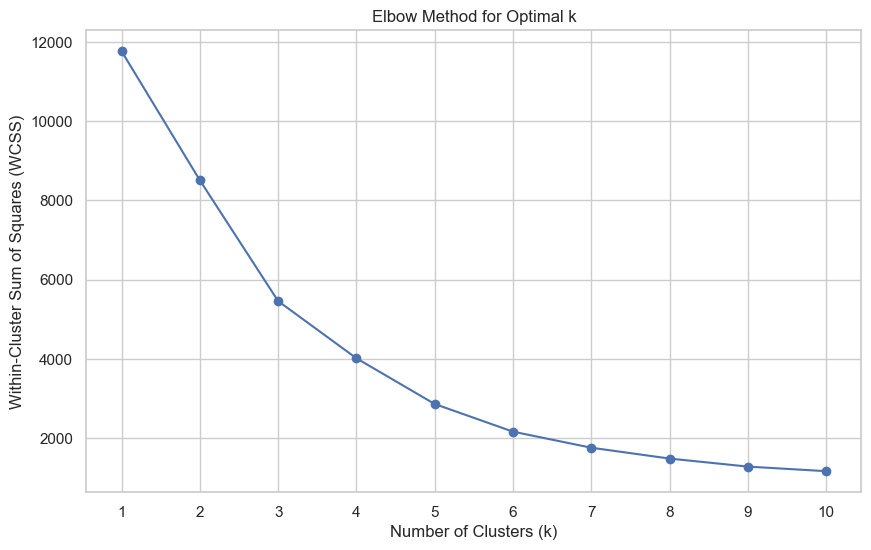

In [59]:
# Customer Segmentation (K-means Clustering) with Elbow Method
# Define a range of clusters to test

k_range = range(1, 11)
wcss = []  # Within-cluster sum of squares

# Calculate WCSS for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # Inertia is another name for WCSS

# Plot the Elbow Method curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [60]:
# Define a range of clusters to test
k_range = [3, 4, 5, 6]

best_silhouette_score = -1  # Initialize with a negative value
best_kmeans_model = None

for k in k_range:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    rfm_df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Evaluate the clustering model using silhouette score
    silhouette_avg = silhouette_score(scaled_features, rfm_df['Cluster'])
    print("For k =", k, "Silhouette Score:", silhouette_avg)
    
    # Save the best model based on silhouette score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_kmeans_model = kmeans

# Save the Best Model
joblib.dump(best_kmeans_model, 'best_customer_segmentation_model.pkl')


For k = 3 Silhouette Score: 0.5925840190221153
For k = 4 Silhouette Score: 0.5956624364378685
For k = 5 Silhouette Score: 0.6169392038733394
For k = 6 Silhouette Score: 0.5918832466572921


['best_customer_segmentation_model.pkl']